In [2]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import mpld3
from mpld3 import plugins


/Users/noma/OneDrive_UTA/OneDrive - UT Arlington/mac/WorkSpace/FG-ETH/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def get_fear_greed_data(limit=30):
    url = f"https://api.alternative.me/fng/?limit={limit}&format=json&date_format=us"
    response = requests.get(url)
    data = response.json()["data"]
    # Convert the data into a DataFrame
    fear_greed_df = pd.DataFrame(data)
    fear_greed_df['date'] = pd.to_datetime(fear_greed_df['timestamp']).dt.date
    fear_greed_df['value'] = fear_greed_df['value'].astype(int)
    return fear_greed_df[['date','value_classification' ,'value']]

In [28]:
fear_greed_df = get_fear_greed_data(365*2) 
fear_greed_df

,date,value_classification,value
0,2024-10-05,Neutral,49
1,2024-10-04,Fear,41
2,2024-10-03,Fear,37
3,2024-10-02,Fear,42
4,2024-10-01,Neutral,50
...,...,...,...
725,2022-10-11,Extreme Fear,24
726,2022-10-10,Extreme Fear,22
727,2022-10-09,Extreme Fear,22
728,2022-10-08,Extreme Fear,24


In [44]:
import requests

url = "https://rest.coinapi.io/v1/exchangerate/BTC/USD/history?period_id=1DAY"

payload = {}
headers = {
  'Accept': 'text/plain',
  "X-CoinAPI-Key": '0619394E-1016-4BB5-BADC-558EE8C4878E'
}

response = requests.request("GET", url, headers=headers, data=payload)

print(response.text)


[
  {
    "time_period_start": "2024-10-05T00:00:00.0000000Z",
    "time_period_end": "2024-10-06T00:00:00.0000000Z",
    "time_open": "2024-10-05T00:00:00.0000000Z",
    "time_close": "2024-10-05T23:26:20.1000000Z",
    "rate_open": 62089.1432884622,
    "rate_high": 62374.515870509,
    "rate_low": 61686.0401065012,
    "rate_close": 62018.0795433617
  },
  {
    "time_period_start": "2024-10-04T00:00:00.0000000Z",
    "time_period_end": "2024-10-05T00:00:00.0000000Z",
    "time_open": "2024-10-04T00:00:00.0000000Z",
    "time_close": "2024-10-04T23:59:51.6000000Z",
    "rate_open": 60745.7596980546,
    "rate_high": 62475.5642647252,
    "rate_low": 60455.6767504654,
    "rate_close": 62079.6846156221
  },
  {
    "time_period_start": "2024-10-03T00:00:00.0000000Z",
    "time_period_end": "2024-10-04T00:00:00.0000000Z",
    "time_open": "2024-10-03T00:00:00.0000000Z",
    "time_close": "2024-10-03T23:59:59.4000000Z",
    "rate_open": 60638.1732178172,
    "rate_high": 61460.23630388

In [56]:
end_date = date.today().isoformat()
end_date


'2024-10-05'

In [59]:
import requests
import pandas as pd
from datetime import datetime, timedelta,date

# API from coinapi

def get_historical_price_data(symbol, start_date, end_date, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD/history"
    
    headers = {
        "X-CoinAPI-Key": api_key
    }
    
    params = {
        "period_id": "1DAY",
        "time_start": start_date.isoformat(),
        "time_end": end_date.isoformat(),
        "limit": 10000
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    
    if not isinstance(data, list) or len(data) == 0:
        print(f"Unexpected API response: {data}")
        return pd.DataFrame(columns=['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price'])
    
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['time_period_start']).dt.date
    df = df.rename(columns={'rate_open': 'daily_min_price', 'rate_high': 'daily_max_price', 'rate_close': 'daily_avg_price'})
    return df[['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price']]


# Replace with your actual CoinAPI key
api_key = "0619394E-1016-4BB5-BADC-558EE8C4878E"

def get_eth_price_data(days=30):
    end_date = date.today()
    start_date = end_date - timedelta(days=days)
    return get_historical_price_data("ETH", start_date, end_date, api_key)

def get_bitcoin_price_data(days=30):
    end_date = date.today()
    start_date = end_date - timedelta(days=days)
    return get_historical_price_data("BTC", start_date, end_date, api_key)

#Usage example:

# bitcoin_df = get_bitcoin_price_data(time_period)


TypeError: 'int' object is not callable

In [60]:
time_period = 730  # 2 years
eth_df = get_eth_price_data(time_period)
eth_df.head(1000)

,date,daily_min_price,daily_max_price,daily_avg_price
0,2022-10-06,1352.515945,1382.295962,1352.231903
1,2022-10-07,1352.231897,1360.411026,1331.274037
2,2022-10-08,1330.823838,1337.254541,1315.560224
3,2022-10-09,1314.475239,1328.567508,1323.297696
4,2022-10-10,1322.987562,1337.684391,1289.983690
...,...,...,...,...
95,2023-01-09,1289.736584,1344.265778,1320.353164
96,2023-01-10,1320.380228,1344.149340,1335.709581
97,2023-01-11,1335.725273,1394.943852,1389.293763
98,2023-01-12,1389.569729,1434.793767,1416.070827


In [4]:
# API from coin gecko
def get_eth_price_data(days=30):
    url = f"https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days={days}"
    response = requests.get(url)
    prices = response.json()["prices"]
    eth_df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'], unit='ms')
    # calculate daily min max mean price
    eth_df['date'] = eth_df['timestamp'].dt.date
    daily_min_max = eth_df.groupby('date')['price'].agg(['min', 'max','mean'])
    eth_daily_min_max = daily_min_max.rename(columns={'min': 'daily_min_price', 'max': 'daily_max_price','mean':'daily_avg_price'})
    return eth_daily_min_max.reset_index()

In [31]:
def get_bitcoin_price_data(days=30):
    url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days={days}"
    response = requests.get(url)
    prices = response.json()["prices"]
    eth_df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'], unit='ms')
    # calculate daily min max mean price
    eth_df['date'] = eth_df['timestamp'].dt.date
    daily_min_max = eth_df.groupby('date')['price'].agg(['min', 'max','mean'])
    eth_daily_min_max = daily_min_max.rename(columns={'min': 'daily_min_price', 'max': 'daily_max_price','mean':'daily_avg_price'})
    return eth_daily_min_max.reset_index()

In [29]:
eth_daily_min_max = get_eth_price_data(366)




KeyError: 'prices'

In [77]:
eth_daily_min_max.head(10)



,date,daily_min_price,daily_max_price,daily_avg_price
0,2024-09-05,2365.613946,2373.846891,2370.013683
1,2024-09-06,2192.875978,2400.259982,2323.295560
2,2024-09-07,2225.447418,2298.831479,2270.811571
3,2024-09-08,2252.099768,2307.071211,2283.875215
4,2024-09-09,2279.440221,2374.355151,2319.061904
5,2024-09-10,2323.076899,2396.416719,2353.136991
6,2024-09-11,2283.583650,2379.673435,2339.304261
7,2024-09-12,2322.784915,2370.094683,2351.816474
8,2024-09-13,2339.545925,2453.809057,2378.893883
9,2024-09-14,2397.090638,2445.086210,2420.141635


In [67]:
fear_greed_df


,date,value_classification,value
0,2024-10-05,Neutral,49
1,2024-10-04,Fear,41
2,2024-10-03,Fear,37
3,2024-10-02,Fear,42
4,2024-10-01,Neutral,50
5,2024-09-30,Greed,61
6,2024-09-29,Greed,63
7,2024-09-28,Greed,64
8,2024-09-27,Greed,61
9,2024-09-26,Neutral,50


In [5]:
def merge_data(fear_greed_df, eth_df):
    # Merge the two DataFrames on the 'timestamp' column
    merged_df = pd.merge(fear_greed_df, eth_df, on='date', how='inner')
    return merged_df

In [82]:
eth_daily_min_max.dtypes
#fear_greed_df.dtypes

date                object
daily_min_price    float64
daily_max_price    float64
daily_avg_price    float64
dtype: object

In [6]:
eth_daily_min_max = get_eth_price_data(120)
fear_greed_df = get_fear_greed_data(120)
merged_df = merge_data(eth_daily_min_max, fear_greed_df)
merged_df.head(10)



,date,daily_min_price,daily_max_price,daily_avg_price,value_classification,value
0,2024-06-08,3679.376652,3679.376652,3679.376652,Greed,72
1,2024-06-09,3683.025380,3683.025380,3683.025380,Greed,75
2,2024-06-10,3705.899884,3705.899884,3705.899884,Greed,72
3,2024-06-11,3666.827665,3666.827665,3666.827665,Greed,74
4,2024-06-12,3498.555954,3498.555954,3498.555954,Greed,72
5,2024-06-13,3559.447534,3559.447534,3559.447534,Greed,70
6,2024-06-14,3465.316584,3465.316584,3465.316584,Greed,74
7,2024-06-15,3478.774835,3478.774835,3478.774835,Greed,74
8,2024-06-16,3565.123259,3565.123259,3565.123259,Greed,71
9,2024-06-17,3618.508653,3618.508653,3618.508653,Greed,71


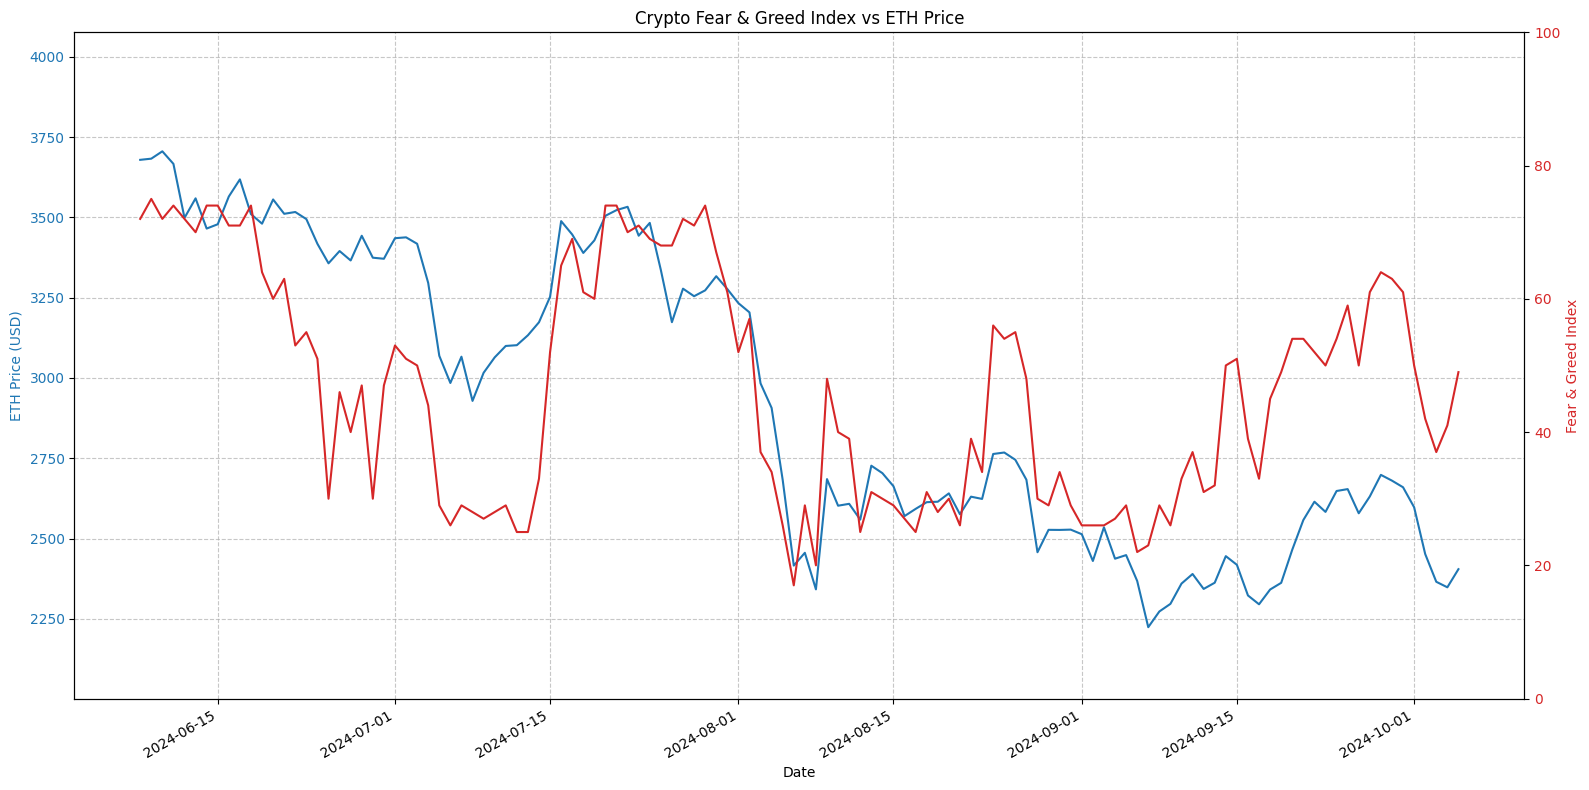

In [193]:
def plot_data(merged_df):
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')

    # Plot ETH Price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('ETH Price (USD)', color='tab:blue')
    line1 = ax1.plot(merged_df['date'], merged_df['daily_avg_price'], color='tab:blue', label='ETH Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot Fear & Greed Index on secondary Y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Fear & Greed Index', color='tab:red')
    line2 = ax2.plot(merged_df['date'], merged_df['value'], color='tab:red', label='Fear & Greed Index')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Set y-axis limits for both axes
    ax1.set_ylim(merged_df['daily_avg_price'].min() * 0.9, merged_df['daily_avg_price'].max() * 1.1)
    ax2.set_ylim(0, 100)

    # Adjust x-axis to show all dates
    plt.xticks(rotation=90, ha='center')
    fig.autofmt_xdate()

    # Add grid for better readability
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Add legend
    # lines = line1 + line2
    # labels = [l.get_label() for l in lines]
    # ax1.legend(lines, labels, loc='upper right')

    plt.title('Crypto Fear & Greed Index vs ETH Price')
    fig.tight_layout()

    # Add tooltips
    tooltip1 = plugins.LineLabelTooltip(line1[0], label='ETH Price: ${}'.format(merged_df['daily_avg_price'].tolist()))
    tooltip2 = plugins.LineLabelTooltip(line2[0], label='Fear & Greed Index: {}'.format(merged_df['value'].tolist()))
    plugins.connect(fig, tooltip1, tooltip2)

    # Add interactive legend
    #interactive_legend = plugins.InteractiveLegendPlugin(lines, labels, alpha_unsel=0.1)
    #plugins.connect(fig, interactive_legend)

    # Create interactive plot
    interactive_plot = mpld3.fig_to_html(fig)
    return interactive_plot

# Usage
fear_greed_df = get_fear_greed_data(limit=120)  # Last 120 days
eth_df = get_eth_price_data(days=120)  # Last 120 days

# Merge and plot
merged_df = merge_data(fear_greed_df, eth_df)
interactive_html = plot_data(merged_df)



In [188]:
# Display the interactive plot in a Jupyter notebook
from IPython.display import HTML
HTML(interactive_html)



In [184]:
with open('interactive_plot.html', 'w') as f:
    f.write(interactive_html)

In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_data(merged_df):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=merged_df['date'], y=merged_df['daily_avg_price'], name="ETH Price", line=dict(color='blue')),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=merged_df['date'], y=merged_df['value'], name="Fear & Greed Index", line=dict(color='red')),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="Crypto Fear & Greed Index vs ETH Price",
        xaxis_title="Date",
        yaxis_title="ETH Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(x=0.71, y=0.99, bgcolor='rgba(255, 255, 255, 0.5)'),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_avg_price'].min() * 0.9, merged_df['daily_avg_price'].max() * 1.1], secondary_y=False)
    fig.update_yaxes(range=[0, 100], secondary_y=True)

    return fig

# Usage
time_period = 365
fear_greed_df = get_fear_greed_data(time_period)  # Last 120 days
eth_df = get_eth_price_data(time_period)  # Last 120 days
bitcoin_df = get_bitcoin_price_data(time_period)  # Last 120 days
# Merge and plot
merged_eth_fg_df = merge_data(fear_greed_df, eth_df)
fig = plot_data(merged_eth_fg_df)

# Display the interactive plot in a Jupyter notebook
fig.show()

# To save as HTML file
#fig.write_html("interactive_plot.html")

In [33]:
bitcoin_df = get_bitcoin_price_data(time_period)  # Last 120 days
# Merge and plot
merged_bitcoin_fg_df = merge_data(fear_greed_df, bitcoin_df)
fig = plot_data(merged_bitcoin_fg_df)

# Display the interactive plot in a Jupyter notebook
fig.show()